Generate my own data $x_i \sim \mbox{Gamma}(\alpha=1.5, \beta=60)$ and check that my method recover this. Use fairly few samples, and use only one term in $\alpha$ and $\beta$ polynomials. No need to transform from $\ell \to x$, we generate in $x$ directly

In [1]:
import Distributions, LaTeXStrings,optim, Plots, PyCall, Asymptotic

In [2]:
font = Plots.font("TeX Gyre Heros")
myfonts = Dict(:guidefont=>font,
:xtickfont=>font, :ytickfont=>font, :legendfont=>font);
Plots.pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)

Plots.PyPlotBackend()

In [49]:
α0 = 2; β0 = 60.
νmin=0.
νmax=10.

10.0

Do we need to make up frequencies? Not really, we just care about one bin, but for compatibility, we do

In [50]:
# define order of linear models
αOrder = 1
βOrder = 1
npackets=1000

# read in data from tardis and create posterior
dim = αOrder + βOrder
∇res, Hres = optim.allocations(dim)
frame, (P, ∇P!, HP!) = optim.problem(αOrder=αOrder, βOrder=βOrder, run=99, npackets=npackets);

# now change the energies
PyCall.@pyimport numpy.random as nprand
nprand.seed(1358)
PyCall.@pyimport scipy.stats as stats
dist0 = stats.gamma(α0, scale=1/β0)
# crucial: change frame in place, else optimization runs with old energies!
frame[:energies][:] = dist0[:rvs](size=length(frame[:energies]))
# Plots.histogram(frame[:energies])

# the observed number of packets in the bin
nmin=searchsortedfirst(frame[:nus], νmin)
nmax=searchsortedlast(frame[:nus], νmax)
n = nmax - nmin + 1
x = sum(frame[:energies][nmin:nmax])
n,x

# for testing
# n = 291
# x= 7.389999302674019

(731,24.98829726298286)

In [51]:
# compute the posterior mode to estimate the evidence
# start optimization at true values
@time maxP, posterior_mode, ret = optim.run_nlopt(frame, P, ∇P!, HP!,
    αOrder, βOrder, xtol_rel=1e-4, init=1.001*[α0, β0])
HP!(posterior_mode, Hres)
evidence = optim.laplace(maxP, Hres)
println("got $maxP at $(posterior_mode) (returned $ret) and evidence $evidence")

  0.106222 seconds (1.90 M allocations: 29.149 MB, 9.94% gc time)
got 1833.657516233961 at [2.11409,61.8471] (returned XTOL_REACHED) and evidence 1833.675998766634


Asymptotic
------

We will use all samples to compute the mean and variance but then focus on one $\nu$ bin to get the prediction as above

In [52]:
#index = searchsortedfirst(frame[:nus], νmin)
#samples = frame[:energies][index:index+n+1]
samples = frame[:energies][nmin:nmax]
xmean, sumsqdiff = mean(samples), (n-1)*var(samples)
asymp_res = Asymptotic.uncertainty(n, xmean, sumsqdiff, 1.)
distasympt=Distributions.Normal(asymp_res[1], asymp_res[2])


Distributions.Normal(μ=24.85231178493502, σ=2.428225339867508)

Sum over N
----

In [53]:
# compute the posterior mode to estimate the evidence
# start optimization at true values
@time maxP, posterior_mode, ret = optim.run_nlopt(frame, P, ∇P!, HP!,
    αOrder, βOrder, xtol_rel=1e-3, init=1.001*[α0, β0])
HP!(posterior_mode, Hres)
evidence = optim.laplace(maxP, Hres)
println("got $maxP at $(posterior_mode) (returned $ret) and evidence $evidence")

  0.039719 seconds (895.26 k allocations: 13.671 MB, 12.65% gc time)
got 1833.6501479074886 at [2.10289,61.4386] (returned XTOL_REACHED) and evidence 1833.6590220581927


The mode matches the input values well

In [54]:
# the posterior mean with the normalized posterior
# predict at bin center
# ν, X, N
#pm = optim.PosteriorMean((νmax + νmin)/2, x, convert(Float64, n))
pm = optim.PosteriorMean(1.0, x, convert(Float64, n))
Pmean, ∇Pmean!, HPmean! = optim.targetfactory(frame, αOrder, βOrder, evidence=evidence, pm=pm)
@time maxPmean, mean_mode, ret = optim.run_nlopt(frame, Pmean, ∇Pmean!, HPmean!, αOrder, βOrder,
init=posterior_mode, xtol_rel=1e-6)
println("max of normalized posterior = $maxPmean at $(mean_mode), returned $ret")

# n, a
nb = optim.NegBinom(n, 1.);

  0.197428 seconds (5.30 M allocations: 80.902 MB, 7.08% gc time)
max of normalized posterior = -0.46704687892133734 at [2.11676,61.923], returned XTOL_REACHED


The **mode comes out pretty much at the input values** 

In [55]:
# compute points from asymptotic approx.
points = collect(linspace(max( asymp_res[1] - 3asymp_res[2], 0.0), asymp_res[1] + 3asymp_res[2], 25))
#points = collect(linspace(max(x-4, 0.0), x+1, 25))
distn = stats.gamma(n*α0, scale=1/β0)
# points = collect(linspace(distn[:ppf](1e-6), dist0[:ppf](1-1e-6), 25))
results = zeros(points)
# skip X = 0, start at 2
for i in 2:length(points)
    pm.X = points[i]
    results[i] = optim.predict_small(frame, Pmean, ∇Pmean!, HPmean!, pm, αOrder, βOrder, posterior_mode,
    nb, optimize=false)
end

initial N=566
initial N=580
initial N=594
initial N=614
initial N=628
initial N=642
initial N=653
initial N=673
initial N=684
initial N=699
initial N=712
initial N=727
initial N=741
initial N=755
initial N=770
initial N=784
initial N=800
initial N=815
initial N=831
initial N=837
initial N=852
initial N=866
initial N=881
initial N=895


In [65]:
simp = tardis.simpson(points, results)
info("Simpson: normalization=$(simp[1]), mean=$(simp[2]), σ=$(simp[3])")
results /= simp[1]
# now repeat to get the right σ
simp = tardis.simpson(points, results)
info("Simpson: normalization=$(simp[1]), mean=$(simp[2]), σ=$(simp[3])")


INFO: Simpson: normalization=1.0000000000000002, mean=24.999305095819917, σ=1.4552277852420457
INFO: Simpson: normalization=0.9999999999999999, mean=24.999305095819913, σ=1.4552277852420457


Plot and compare
----


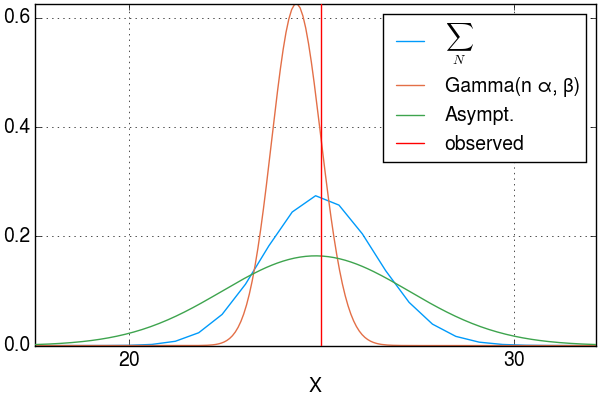

In [66]:
using LaTeXStrings, StatPlots
compare = function(points, results, x; distn=nothing, distasympt=nothing)
    Plots.plot(points, results, xlabel="X", label=L"\sum_N")
    finepoints = collect(linspace(points[1], points[end], 200))
    if distn !== nothing        
        Plots.plot!(finepoints, distn[:pdf](finepoints), label="Gamma(n α, β)")
    end
    if distasympt !== nothing
        Plots.plot!(finepoints, Distributions.pdf(distasympt, finepoints),
        label="Asympt.")
    end
    # vline at the end to plot all the way
    Plots.vline!([x], line=:red, label="observed")
end

compare(points, results, x; distn=distn, distasympt=distasympt)

In [58]:
n

731


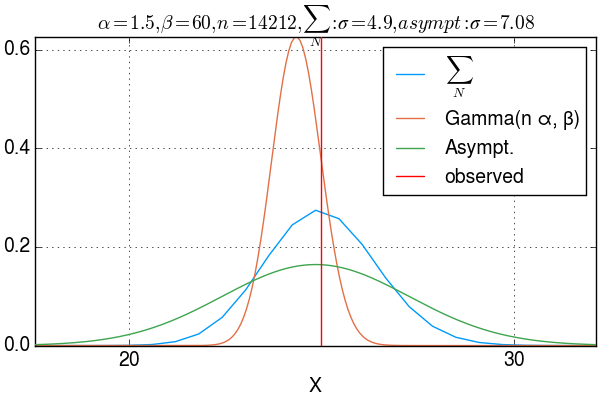

In [59]:
plot!(title=L"\alpha=1.5, \beta=60, n=14212, \sum_N: σ=4.9, asympt: σ=7.08", )
Plots.pdf("Qcompare-n14212")
plot!()

where does the variance come from
-----

If we use only 1000 instead of 10000 samples, prediction nearly identical $\Rightarrow$ broadening is due to the Poisson term

For compound Poisson,
$$V[Q] = V[X] \lambda + E[X^2] \lambda = \lambda E[X^2]$$

and for large $\lambda$, $\lambda \approx n$, so variance of compound 
$$V[Q] \propto n$$, so how well is Q known from $n$ samples? The usual answer
$$\sqrt{V[Q]}/Q \propto 1/\sqrt{n}$$

In [60]:
α0 / β0^2 * n, α0 / β0^2 *(1 + α0)

(0.4061111111111111,0.0016666666666666666)

Check optimizer
------

Is cobyla not working right?

In [61]:
using Optim

optimize(x->-P(x), 1.05*[α0, β0], BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [2.1,63.0]
 * Minimizer: [2.1142622968731173,61.8499821231765]
 * Minimum: -1.833658e+03
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 31
 * Gradient Calls: 31

In [62]:
α0/β0^2 *(length(frame[:energies])-1)

0.40555555555555556


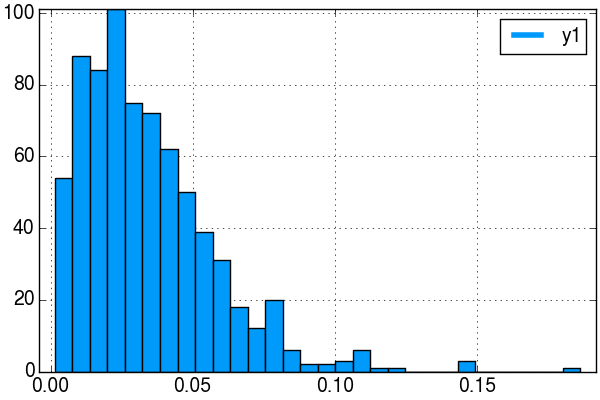

In [63]:
Plots.histogram(frame[:energies])


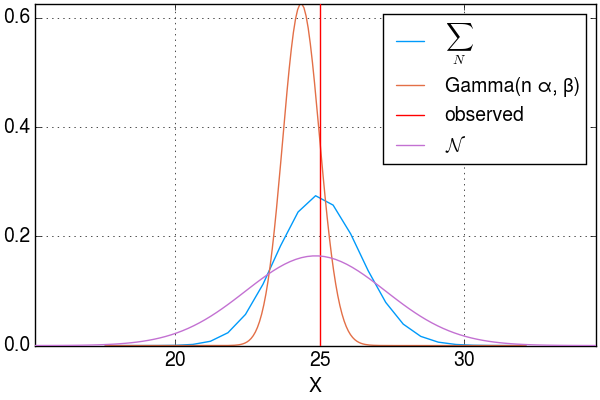

In [64]:
reload("Asymptotic")
asymp_res = Asymptotic.uncertainty(n, xmean, sumsqdiff, 0.)

compare(points, results, x; distn=distn)
Plots.plot!(distasympt, label=L"\mathcal{N}")